# Эта ячейка задает пути, создает папку outputs/, находит все годовые файлы flare_list и country_summary, проверяет что годы 2012-2019 присутствуют, и сохраняет манифест файлов в outputs/file_manifest.csv. В конце выводится таблица манифеста на экран.

In [1]:
import os
import re
import glob
from pathlib import Path

import numpy as np
import pandas as pd

# Paths
DATA_DIR = Path("/content")
OUT_DIR = Path("/content/outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# File patterns
flare_pat = str(DATA_DIR / "eog_global_flare_survey_*_flare_list.csv")
country_pat = str(DATA_DIR / "eog_global_flare_survey_*_country_summary.csv")

flare_files = sorted(glob.glob(flare_pat))
country_files = sorted(glob.glob(country_pat))

def _extract_year(fp: str) -> int:
    m = re.search(r"eog_global_flare_survey_(\d{4})_", os.path.basename(fp))
    return int(m.group(1)) if m else None

manifest_rows = []
for fp in flare_files:
    manifest_rows.append({"file_type": "flare_list", "year": _extract_year(fp), "path": fp})
for fp in country_files:
    manifest_rows.append({"file_type": "country_summary", "year": _extract_year(fp), "path": fp})

df_manifest = pd.DataFrame(manifest_rows).dropna(subset=["year"]).sort_values(["file_type", "year"]).reset_index(drop=True)

# Basic checks
expected_years = set(range(2012, 2020))
years_flare = set(df_manifest.loc[df_manifest["file_type"] == "flare_list", "year"].astype(int).tolist())
years_country = set(df_manifest.loc[df_manifest["file_type"] == "country_summary", "year"].astype(int).tolist())

missing_flare = sorted(list(expected_years - years_flare))
missing_country = sorted(list(expected_years - years_country))

print(f"Found flare_list files: {len(flare_files)} | years: {sorted(years_flare)}")
print(f"Found country_summary files: {len(country_files)} | years: {sorted(years_country)}")

if missing_flare:
    print(f"WARNING: Missing flare_list years: {missing_flare}")
if missing_country:
    print(f"WARNING: Missing country_summary years: {missing_country}")

# Save manifest
manifest_path = OUT_DIR / "file_manifest.csv"
df_manifest.to_csv(manifest_path, index=False)

# Display on notebook
display(df_manifest)
print(f"Saved: {manifest_path}")


Found flare_list files: 8 | years: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Found country_summary files: 8 | years: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


,file_type,year,path
0,country_summary,2012,/content/eog_global_flare_survey_2012_country_...
1,country_summary,2013,/content/eog_global_flare_survey_2013_country_...
2,country_summary,2014,/content/eog_global_flare_survey_2014_country_...
3,country_summary,2015,/content/eog_global_flare_survey_2015_country_...
4,country_summary,2016,/content/eog_global_flare_survey_2016_country_...
5,country_summary,2017,/content/eog_global_flare_survey_2017_country_...
6,country_summary,2018,/content/eog_global_flare_survey_2018_country_...
7,country_summary,2019,/content/eog_global_flare_survey_2019_country_...
8,flare_list,2012,/content/eog_global_flare_survey_2012_flare_li...
9,flare_list,2013,/content/eog_global_flare_survey_2013_flare_li...


Saved: /content/outputs/file_manifest.csv


# Эта ячейка читает все *_flare_list.csv, добавляет year, приводит типы, заменяет -9999 на NaN, сохраняет полный датасет в outputs/flare_list_all_2012_2019.parquet и дубликат в CSV. В конце выводит: размер, head(), долю пропусков по ключевым полям.

In [2]:
import os
import re
import pandas as pd
import numpy as np

from pathlib import Path

OUT_DIR = Path("/content/outputs")
df_manifest = pd.read_csv(OUT_DIR / "file_manifest.csv")

flare_paths = df_manifest.loc[df_manifest["file_type"] == "flare_list", "path"].tolist()

def extract_year(fp: str) -> int:
    m = re.search(r"eog_global_flare_survey_(\d{4})_", os.path.basename(fp))
    return int(m.group(1)) if m else None

flare_cols_expected = [
    "cntry_name","cntry_iso","catalog_id","id_number","latitude","longitude",
    "flr_volume","avg_temp","ellip","dtc_freq","clr_obs","flr_type"
]

def read_flare_list(fp: str) -> pd.DataFrame:
    df = pd.read_csv(fp)
    df.columns = [c.strip().strip('"') for c in df.columns]

    missing = [c for c in flare_cols_expected if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in {os.path.basename(fp)}: {missing}")

    df = df[flare_cols_expected].copy()
    df["year"] = extract_year(fp)

    num_cols = ["id_number","latitude","longitude","flr_volume","avg_temp","ellip","dtc_freq","clr_obs"]
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        df.loc[df[c] == -9999, c] = np.nan

    df["cntry_name"] = df["cntry_name"].astype(str).str.strip().str.replace('"', '', regex=False)
    df["cntry_iso"] = df["cntry_iso"].astype(str).str.strip().str.replace('"', '', regex=False)
    df["catalog_id"] = df["catalog_id"].astype(str).str.strip().str.replace('"', '', regex=False)
    df["flr_type"] = df["flr_type"].astype(str).str.strip().str.replace('"', '', regex=False)

    return df

dfs = [read_flare_list(p) for p in flare_paths]
df_flare_all = pd.concat(dfs, ignore_index=True)

# Basic QC: coordinate ranges (not filtering yet, only reporting)
coord_ok = (
    df_flare_all["latitude"].between(-90, 90, inclusive="both") &
    df_flare_all["longitude"].between(-180, 180, inclusive="both")
)
print(f"Rows total: {len(df_flare_all):,}")
print(f"Valid coord rows: {coord_ok.sum():,} ({coord_ok.mean()*100:.2f}%)")

# Save
out_parquet = OUT_DIR / "flare_list_all_2012_2019.parquet"
out_csv = OUT_DIR / "flare_list_all_2012_2019.csv"

df_flare_all.to_parquet(out_parquet, index=False)
df_flare_all.to_csv(out_csv, index=False)

# Display
display(df_flare_all.head(10))

na_report = (
    df_flare_all[["latitude","longitude","flr_volume","dtc_freq","clr_obs"]]
    .isna()
    .mean()
    .sort_values(ascending=False)
    .rename("missing_fraction")
    .to_frame()
)
display(na_report)

print(f"Saved: {out_parquet}")
print(f"Saved: {out_csv}")


Rows total: 83,641
Valid coord rows: 83,641 (100.00%)


,cntry_name,cntry_iso,catalog_id,id_number,latitude,longitude,flr_volume,avg_temp,ellip,dtc_freq,clr_obs,flr_type,year
0,Russian Federation,RUS,VNF_e2012-2015_n20585_x0834803E_y677120N_v1.0,NaN,67.711992,83.480317,1.027877,1808.76,1.66352,99.7925,482.0,upstream,2012
1,Venezuela,VEN,VNF_e2012-2015_n12557_x0635642W_y096467N_v1.0,NaN,9.646733,-63.564198,0.887555,1729.72,1.29884,100.0000,209.0,upstream,2012
2,Venezuela,VEN,VNF_e2012-2015_n12550_x0636245W_y096514N_v1.0,NaN,9.651430,-63.624535,0.796400,1756.16,1.46080,100.0000,201.0,upstream,2012
3,Iran,IRN,VNF_e2012-2015_n18457_x0497140E_y284943N_v1.0,NaN,28.494289,49.713951,0.779953,1661.02,1.72789,100.0000,302.0,upstream,2012
4,Venezuela,VEN,VNF_e2012-2015_n12569_x0634732W_y097358N_v1.0,NaN,9.735795,-63.473241,0.679378,1806.26,1.42614,100.0000,208.0,upstream,2012
5,Iraq,IRQ,VNF_e2012-2015_n17807_x0456636E_y324888N_v1.0,NaN,32.488785,45.663650,0.612615,1714.05,1.27467,99.3220,295.0,upstream,2012
6,Kazakhstan,KAZ,VNF_e2012-2015_n17357_x0574613E_y478800N_v1.0,NaN,47.880032,57.461328,0.551129,1731.29,1.46697,99.4937,395.0,upstream,2012
7,Algeria,DZA,VNF_e2012-2015_n14916_x0060570E_y317990N_v1.0,NaN,31.799048,6.057042,0.521365,1695.48,1.34636,100.0000,316.0,refinery,2012
8,Iraq,IRQ,VNF_e2012-2015_n17869_x0473610E_y302786N_v1.0,NaN,30.278613,47.361021,0.496858,1606.40,0.97305,98.7654,324.0,upstream,2012
9,Russian Federation,RUS,VNF_e2012-2015_n20589_x0835402E_y677928N_v1.0,NaN,67.792785,83.540213,0.466592,1800.46,1.17026,94.8546,447.0,upstream,2012


,missing_fraction
latitude,0.0
longitude,0.0
flr_volume,0.0
dtc_freq,0.0
clr_obs,0.0


Saved: /content/outputs/flare_list_all_2012_2019.parquet
Saved: /content/outputs/flare_list_all_2012_2019.csv


# Эта ячейка читает все *_country_summary.csv, добавляет year, приводит типы, сохраняет общий датасет в outputs/country_summary_all_2012_2019.parquet и CSV. На экран выводятся размер, первые строки и сводка пропусков.

In [3]:
import os
import re
import pandas as pd
import numpy as np
from pathlib import Path

OUT_DIR = Path("/content/outputs")
df_manifest = pd.read_csv(OUT_DIR / "file_manifest.csv")

country_paths = df_manifest.loc[df_manifest["file_type"] == "country_summary", "path"].tolist()

def extract_year(fp: str) -> int:
    m = re.search(r"eog_global_flare_survey_(\d{4})_", os.path.basename(fp))
    return int(m.group(1)) if m else None

country_cols_expected = [
    "cntry_name","cntry_iso",
    "bcm_sum_up","flr_cnt_up",
    "bcm_sum_dn","flr_cnt_dn",
    "bcm_sum_al","flr_cnt_al"
]

def read_country_summary(fp: str) -> pd.DataFrame:
    df = pd.read_csv(fp)
    df.columns = [c.strip().strip('"') for c in df.columns]

    missing = [c for c in country_cols_expected if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in {os.path.basename(fp)}: {missing}")

    df = df[country_cols_expected].copy()
    df["year"] = extract_year(fp)

    num_cols = ["bcm_sum_up","flr_cnt_up","bcm_sum_dn","flr_cnt_dn","bcm_sum_al","flr_cnt_al"]
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        df.loc[df[c] == -9999, c] = np.nan

    df["cntry_name"] = df["cntry_name"].astype(str).str.strip().str.replace('"', '', regex=False)
    df["cntry_iso"] = df["cntry_iso"].astype(str).str.strip().str.replace('"', '', regex=False)

    return df

dfs = [read_country_summary(p) for p in country_paths]
df_country_all = pd.concat(dfs, ignore_index=True)

print(f"Rows total: {len(df_country_all):,}")
print(f"Unique countries: {df_country_all['cntry_iso'].nunique():,}")
print(f"Years: {sorted(df_country_all['year'].unique().tolist())}")

out_parquet = OUT_DIR / "country_summary_all_2012_2019.parquet"
out_csv = OUT_DIR / "country_summary_all_2012_2019.csv"

df_country_all.to_parquet(out_parquet, index=False)
df_country_all.to_csv(out_csv, index=False)

display(df_country_all.head(12))

na_report = (
    df_country_all[["bcm_sum_up","flr_cnt_up","bcm_sum_dn","flr_cnt_dn","bcm_sum_al","flr_cnt_al"]]
    .isna()
    .mean()
    .sort_values(ascending=False)
    .rename("missing_fraction")
    .to_frame()
)
display(na_report)

print(f"Saved: {out_parquet}")
print(f"Saved: {out_csv}")


Rows total: 886
Unique countries: 124
Years: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


,cntry_name,cntry_iso,bcm_sum_up,flr_cnt_up,bcm_sum_dn,flr_cnt_dn,bcm_sum_al,flr_cnt_al,year
0,Russian Federation,RUS,23.731631,2226.0,0.408431,84.0,24.140062,2310.0,2012
1,Iraq,IRQ,12.594036,223.0,0.572550,8.0,13.166587,231.0,2012
2,Iran,IRN,11.028527,429.0,1.361540,13.0,12.390068,442.0,2012
3,United States,USA,9.476321,9199.0,0.387484,154.0,9.863805,9353.0,2012
4,Nigeria,NGA,9.439735,203.0,0.333785,5.0,9.773519,208.0,2012
5,Venezuela,VEN,8.072022,180.0,0.766577,16.0,8.838599,196.0,2012
6,Algeria,DZA,6.950056,328.0,1.819496,14.0,8.769552,342.0,2012
7,Libya,LBY,5.680348,135.0,0.344274,8.0,6.024622,143.0,2012
8,Mexico,MEX,4.267523,236.0,0.972187,15.0,5.239711,251.0,2012
9,Kazakhstan,KAZ,3.930737,272.0,0.022617,2.0,3.953354,274.0,2012


,missing_fraction
bcm_sum_up,0.0
flr_cnt_up,0.0
bcm_sum_dn,0.0
flr_cnt_dn,0.0
bcm_sum_al,0.0
flr_cnt_al,0.0


Saved: /content/outputs/country_summary_all_2012_2019.parquet
Saved: /content/outputs/country_summary_all_2012_2019.csv


# Cразу сделаем фильтрацию региона CA3 (KAZ, UZB, TKM), сохраним эти подмножества в outputs/, и выведем базовые сводки + 2 простых графика (динамика по годам) прямо на экран.

flare_list ALL: 83,641 | CA3: 2,163
country_summary ALL: 886 | CA3: 24
Saved CA3 subsets to outputs/, and samples to sample_data/


,year,cntry_iso,n_sites,n_rows
0,2012,KAZ,161,161
1,2012,TKM,76,76
2,2012,UZB,86,86
3,2013,KAZ,161,161
4,2013,TKM,86,86
5,2013,UZB,90,90
6,2014,KAZ,155,155
7,2014,TKM,82,82
8,2014,UZB,91,91
9,2015,KAZ,151,151


,year,cntry_iso,bcm_sum_al,flr_cnt_al
0,2012,KAZ,3.953354,274.0
1,2012,TKM,2.479396,170.0
2,2012,UZB,1.832913,149.0
3,2013,KAZ,3.752785,274.0
4,2013,TKM,2.293635,170.0
5,2013,UZB,1.504449,149.0
6,2014,KAZ,3.938808,274.0
7,2014,TKM,2.026486,170.0
8,2014,UZB,1.300634,149.0
9,2015,KAZ,3.684737,274.0


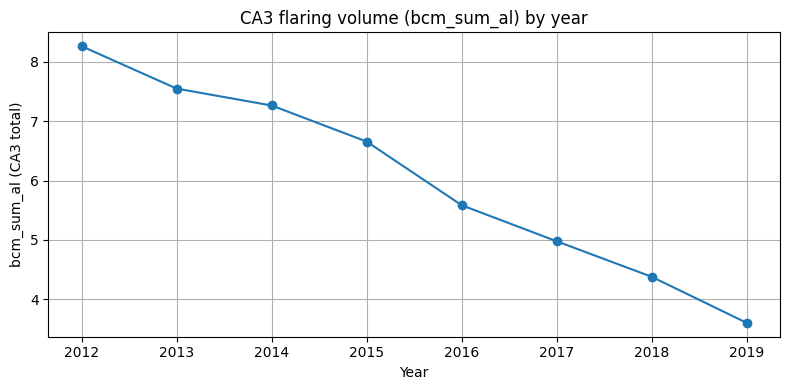

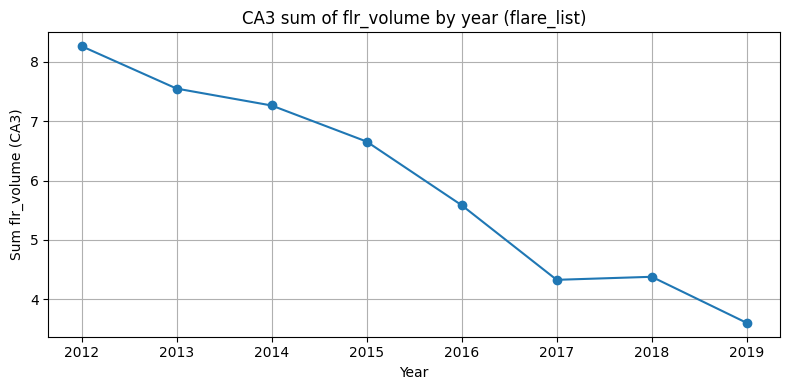

In [5]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import hashlib

OUT_DIR = Path("/content/outputs")
SAMPLE_DIR = Path("/content/sample_data")
SAMPLE_DIR.mkdir(parents=True, exist_ok=True)

ca3_iso = ["KAZ", "UZB", "TKM"]

# Load full tables
df_flare_all = pd.read_parquet(OUT_DIR / "flare_list_all_2012_2019.parquet")
df_country_all = pd.read_parquet(OUT_DIR / "country_summary_all_2012_2019.parquet")

# CA3 subsets
df_flare_ca3 = df_flare_all[df_flare_all["cntry_iso"].isin(ca3_iso)].copy()
df_country_ca3 = df_country_all[df_country_all["cntry_iso"].isin(ca3_iso)].copy()

# Robust site_id (prevents catalog_id collapse in some years)
def make_site_id(row) -> str:
    iso = str(row["cntry_iso"])
    y = int(row["year"])
    lat = row["latitude"]
    lon = row["longitude"]
    if pd.isna(lat) or pd.isna(lon):
        base = f"{iso}|{y}|nan|nan"
    else:
        base = f"{iso}|{y}|{round(float(lat), 5)}|{round(float(lon), 5)}"
    return hashlib.md5(base.encode("utf-8")).hexdigest()

df_flare_ca3["site_id"] = df_flare_ca3.apply(make_site_id, axis=1)

# Save subsets (final CA3 tables used далее в ML)
df_flare_ca3.to_parquet(OUT_DIR / "flare_list_CA3_2012_2019.parquet", index=False)
df_country_ca3.to_parquet(OUT_DIR / "country_summary_CA3_2012_2019.parquet", index=False)

df_flare_ca3.to_csv(OUT_DIR / "flare_list_CA3_2012_2019.csv", index=False)
df_country_ca3.to_csv(OUT_DIR / "country_summary_CA3_2012_2019.csv", index=False)

# Small samples (for repo/demo)
df_flare_ca3.head(200).to_csv(SAMPLE_DIR / "flare_list_CA3_sample_200.csv", index=False)
df_country_ca3.head(200).to_csv(SAMPLE_DIR / "country_summary_CA3_sample_200.csv", index=False)

print(f"flare_list ALL: {len(df_flare_all):,} | CA3: {len(df_flare_ca3):,}")
print(f"country_summary ALL: {len(df_country_all):,} | CA3: {len(df_country_ca3):,}")
print("Saved CA3 subsets to outputs/, and samples to sample_data/")

# Table 1: unique sites by year and country (use site_id, not catalog_id)
tbl_sites_year_ca3 = (
    df_flare_ca3.groupby(["year", "cntry_iso"], as_index=False)
    .agg(n_sites=("site_id", "nunique"), n_rows=("site_id", "size"))
    .sort_values(["year", "cntry_iso"])
)
display(tbl_sites_year_ca3)

# Table 2: country_summary totals by year and country (bcm and counts)
tbl_country_year_ca3 = (
    df_country_ca3.groupby(["year", "cntry_iso"], as_index=False)
    .agg(bcm_sum_al=("bcm_sum_al", "sum"), flr_cnt_al=("flr_cnt_al", "sum"))
    .sort_values(["year", "cntry_iso"])
)
display(tbl_country_year_ca3)

# Plot 1: CA3 total bcm_sum_al by year
ts_bcm_ca3 = df_country_ca3.groupby("year", as_index=False)["bcm_sum_al"].sum().sort_values("year")

plt.figure(figsize=(8, 4))
plt.plot(ts_bcm_ca3["year"], ts_bcm_ca3["bcm_sum_al"], marker="o")
plt.xlabel("Year")
plt.ylabel("bcm_sum_al (CA3 total)")
plt.title("CA3 flaring volume (bcm_sum_al) by year")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: CA3 sum flr_volume by year (flare_list)
ts_flrvol_ca3 = df_flare_ca3.groupby("year", as_index=False)["flr_volume"].sum().sort_values("year")

plt.figure(figsize=(8, 4))
plt.plot(ts_flrvol_ca3["year"], ts_flrvol_ca3["flr_volume"], marker="o")
plt.xlabel("Year")
plt.ylabel("Sum flr_volume (CA3)")
plt.title("CA3 sum of flr_volume by year (flare_list)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Сейчас готовим “таблицу объектов” по одному объекту на site_id, строим матрицу признаков, делаем log1p(flr_volume), масштабируем RobustScaler, сохраняем X_ca3.npy, features_ca3.csv, и выводим: описательную статистику и корреляцию признаков.

Sites (rows): 2,163
Saved: /content/outputs/X_ca3.npy
Saved: /content/outputs/features_ca3.csv
Saved: /content/outputs/scaler_params_ca3.csv


,site_id,year,cntry_iso,cntry_name,latitude,longitude,catalog_id,flr_type,flr_volume_log1p,dtc_freq,clr_obs,avg_temp,ellip
0,000352e063893d9c063581a33ea335c9,2014,UZB,Uzbekistan,39.443698,63.658033,VNF_e2012-2015_n21291_x0636580E_y394437N_v1.0,upstream,0.000832,1.763220,397.0,1351.42,1.60150
1,002b7fe68bd44efc18b25b9d4752038e,2015,UZB,Uzbekistan,38.558074,65.952548,VNF_e2012-2015_n21400_x0659525E_y385581N_v1.0,upstream,0.101936,97.214500,359.0,1711.00,1.32914
2,00324425e9417979993be7b10db8a20c,2018,UZB,Uzbekistan,39.003393,64.109780,UZB_UPS_2018_64.1098E_39.0034N_v3.0,upstream,0.000161,1.000000,382.0,1609.00,1.60000
3,00435e24fe1314f8d2facf8568e4285f,2012,KAZ,Kazakhstan,46.453093,65.637889,VNF_e2012-2015_n20684_x0656379E_y464531N_v1.0,upstream,0.002410,7.416880,391.0,1690.14,1.60150
4,00507728d321e2f4c1be08595f5ae5ef,2012,UZB,Uzbekistan,40.453265,71.799095,VNF_e2012-2015_n20722_x0717991E_y404533N_v1.0,refinery,0.014618,46.715300,274.0,1704.11,2.82536
5,006cbf7ae0f44a472b3561730d5a7ab6,2018,TKM,Turkmenistan,38.575068,64.580858,TKM_UPS_2018_64.5809E_38.5751N_v3.0,upstream,0.000302,1.000000,383.0,1761.00,1.60000
6,0081fc143a3286951c731202d8251728,2014,TKM,Turkmenistan,39.159838,62.553864,VNF_e2012-2015_n21236_x0625539E_y391598N_v1.0,upstream,0.000248,0.248139,403.0,1765.40,1.60150
7,0088dde1835e46153b7cbae9172803b4,2014,TKM,Turkmenistan,38.736742,64.620100,VNF_e2012-2015_n21323_x0646201E_y387367N_v1.0,upstream,0.013948,61.800500,411.0,1833.12,2.49964
8,0093340a9cc8ee90f87250b1bfbdf1a7,2012,KAZ,Kazakhstan,46.429453,64.804215,VNF_e2012-2015_n20644_x0648042E_y464295N_v1.0,upstream,0.000865,4.261360,352.0,1893.12,1.60150
9,00ab3c7b75b98faaef83c931e8653375,2015,UZB,Uzbekistan,38.643082,66.316928,VNF_e2012-2015_n21416_x0663169E_y386431N_v1.0,upstream,0.000262,0.571429,350.0,1695.05,1.60150


,count,mean,std,min,25%,50%,75%,max
flr_volume_log1p,2163.0,0.020439,0.049240,0.00,0.000712,0.00297,0.018702,0.651531
dtc_freq,2163.0,29.086495,35.117016,0.00,1.572805,7.52351,56.105350,100.000000
clr_obs,2163.0,371.924642,39.382695,99.00,347.000000,376.00000,399.000000,471.000000
avg_temp,2163.0,1757.558807,129.699540,1207.84,1694.490000,1767.00000,1827.360000,2456.000000
ellip,2096.0,1.678605,0.455055,0.20,1.600000,1.60150,1.620083,4.936610


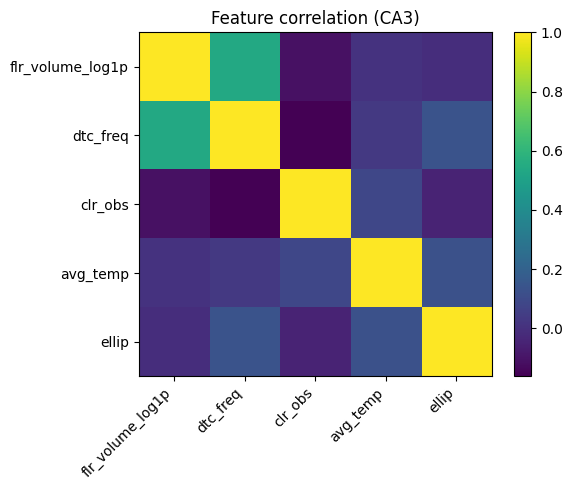

In [6]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler

OUT_DIR = Path("/content/outputs")

df = pd.read_parquet(OUT_DIR / "flare_list_CA3_2012_2019.parquet")

feature_cols = ["flr_volume", "dtc_freq", "clr_obs", "avg_temp", "ellip"]
id_cols = ["site_id", "year", "cntry_iso", "cntry_name", "latitude", "longitude", "catalog_id", "flr_type"]

# Safety aggregation: one row per site_id (in case duplicates appear)
agg = {c: "median" for c in feature_cols}
agg.update({
    "latitude": "median",
    "longitude": "median",
    "year": "first",
    "cntry_iso": "first",
    "cntry_name": "first",
    "catalog_id": "first",
    "flr_type": "first"
})

df_sites = (
    df[id_cols + feature_cols]
    .groupby("site_id", as_index=False)
    .agg(agg)
)

# Transformations
df_sites["flr_volume_log1p"] = np.log1p(df_sites["flr_volume"].astype(float))

model_features = ["flr_volume_log1p", "dtc_freq", "clr_obs", "avg_temp", "ellip"]

# Prepare matrix
X_raw = df_sites[model_features].astype(float).values

scaler = RobustScaler()
X = scaler.fit_transform(X_raw)

# Save artifacts
np.save(OUT_DIR / "X_ca3.npy", X)

scaler_params = pd.DataFrame({
    "feature": model_features,
    "center_": scaler.center_,
    "scale_": scaler.scale_
})
scaler_params.to_csv(OUT_DIR / "scaler_params_ca3.csv", index=False)

df_sites_out = df_sites[["site_id", "year", "cntry_iso", "cntry_name", "latitude", "longitude", "catalog_id", "flr_type"] + model_features].copy()
df_sites_out.to_csv(OUT_DIR / "features_ca3.csv", index=False)

print(f"Sites (rows): {len(df_sites_out):,}")
print(f"Saved: {OUT_DIR / 'X_ca3.npy'}")
print(f"Saved: {OUT_DIR / 'features_ca3.csv'}")
print(f"Saved: {OUT_DIR / 'scaler_params_ca3.csv'}")

# Display head + stats
display(df_sites_out.head(10))

desc = df_sites_out[model_features].describe().T
display(desc)

# Correlation heatmap (matplotlib only)
corr = df_sites_out[model_features].corr()

plt.figure(figsize=(6, 5))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(model_features)), model_features, rotation=45, ha="right")
plt.yticks(range(len(model_features)), model_features)
plt.title("Feature correlation (CA3)")
plt.colorbar()
plt.tight_layout()
plt.show()



# Эта ячейка: загружает X_ca3.npy и features_ca3.csv, восстанавливает X из features (чтобы корректно обработать NaN в ellip и не зависеть от старого X), заполняет NaN медианой, считает silhouette и Davies-Bouldin для k=2..6, сохраняет графики в outputs/, обучает финальный KMeans с k=3, сохраняет kmeans_labels_ca3.csv и таблицу features_ca3_with_cluster.csv, выводит на экран таблицу метрик и первые строки.

,k,silhouette,davies_bouldin
0,2,0.773229,0.508579
1,3,0.729953,0.493807
2,4,0.752111,0.483546
3,5,0.735146,0.503207
4,6,0.755622,0.477674


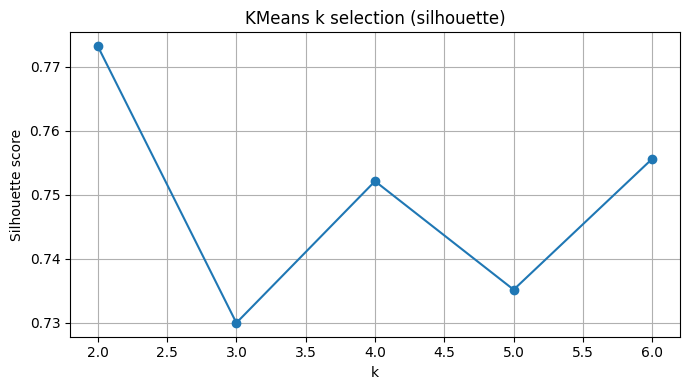

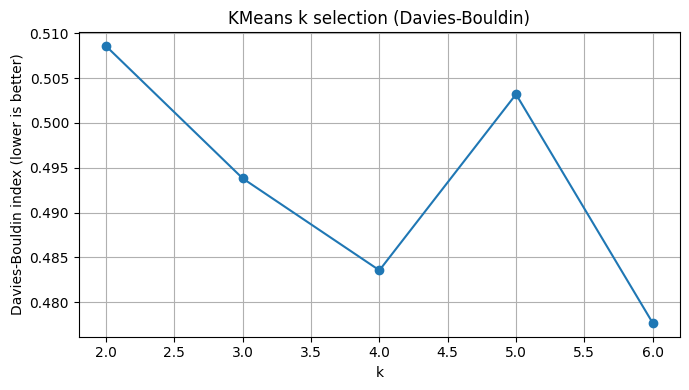

Saved: /content/outputs/k_selection_silhouette_ca3.png
Saved: /content/outputs/k_selection_davies_bouldin_ca3.png
Saved: /content/outputs/features_ca3_with_cluster.csv
Saved: /content/outputs/kmeans_labels_ca3.csv


,site_id,year,cntry_iso,cntry_name,latitude,longitude,catalog_id,flr_type,cluster
0,000352e063893d9c063581a33ea335c9,2014,UZB,Uzbekistan,39.443698,63.658033,VNF_e2012-2015_n21291_x0636580E_y394437N_v1.0,upstream,0
1,002b7fe68bd44efc18b25b9d4752038e,2015,UZB,Uzbekistan,38.558074,65.952548,VNF_e2012-2015_n21400_x0659525E_y385581N_v1.0,upstream,0
2,00324425e9417979993be7b10db8a20c,2018,UZB,Uzbekistan,39.003393,64.109780,UZB_UPS_2018_64.1098E_39.0034N_v3.0,upstream,0
3,00435e24fe1314f8d2facf8568e4285f,2012,KAZ,Kazakhstan,46.453093,65.637889,VNF_e2012-2015_n20684_x0656379E_y464531N_v1.0,upstream,0
4,00507728d321e2f4c1be08595f5ae5ef,2012,UZB,Uzbekistan,40.453265,71.799095,VNF_e2012-2015_n20722_x0717991E_y404533N_v1.0,refinery,1
5,006cbf7ae0f44a472b3561730d5a7ab6,2018,TKM,Turkmenistan,38.575068,64.580858,TKM_UPS_2018_64.5809E_38.5751N_v3.0,upstream,0
6,0081fc143a3286951c731202d8251728,2014,TKM,Turkmenistan,39.159838,62.553864,VNF_e2012-2015_n21236_x0625539E_y391598N_v1.0,upstream,0
7,0088dde1835e46153b7cbae9172803b4,2014,TKM,Turkmenistan,38.736742,64.620100,VNF_e2012-2015_n21323_x0646201E_y387367N_v1.0,upstream,1
8,0093340a9cc8ee90f87250b1bfbdf1a7,2012,KAZ,Kazakhstan,46.429453,64.804215,VNF_e2012-2015_n20644_x0648042E_y464295N_v1.0,upstream,0
9,00ab3c7b75b98faaef83c931e8653375,2015,UZB,Uzbekistan,38.643082,66.316928,VNF_e2012-2015_n21416_x0663169E_y386431N_v1.0,upstream,0


,flr_volume_log1p,dtc_freq,clr_obs,avg_temp,ellip
cluster,,,,,
0,0.002143,4.48146,377.0,1767.600,1.60150
1,0.012352,47.27270,369.0,1787.000,2.51000
2,0.009453,38.98260,369.0,1737.005,1.09136


In [7]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

OUT_DIR = Path("/content/outputs")

df_sites = pd.read_csv(OUT_DIR / "features_ca3.csv")

model_features = ["flr_volume_log1p", "dtc_freq", "clr_obs", "avg_temp", "ellip"]

# Impute NaN (only ellip has missing in your run, but do it generally)
medians = df_sites[model_features].median(numeric_only=True)
df_sites[model_features] = df_sites[model_features].fillna(medians)

# Scale (re-fit scaler for reproducibility with imputation)
scaler = RobustScaler()
X = scaler.fit_transform(df_sites[model_features].astype(float).values)

# k selection
k_range = list(range(2, 7))
rows = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    rows.append({"k": k, "silhouette": sil, "davies_bouldin": dbi})

df_k = pd.DataFrame(rows)
display(df_k)

# Save metric plots
plt.figure(figsize=(7, 4))
plt.plot(df_k["k"], df_k["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("KMeans k selection (silhouette)")
plt.grid(True)
plt.tight_layout()
plt.savefig(OUT_DIR / "k_selection_silhouette_ca3.png", dpi=300)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(df_k["k"], df_k["davies_bouldin"], marker="o")
plt.xlabel("k")
plt.ylabel("Davies-Bouldin index (lower is better)")
plt.title("KMeans k selection (Davies-Bouldin)")
plt.grid(True)
plt.tight_layout()
plt.savefig(OUT_DIR / "k_selection_davies_bouldin_ca3.png", dpi=300)
plt.show()

# Final model (fixed k=3 for MVP)
k_final = 3
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=50)
df_sites["cluster"] = kmeans.fit_predict(X)

# Save clusters + model inputs
df_sites.to_csv(OUT_DIR / "features_ca3_with_cluster.csv", index=False)

labels_out = df_sites[["site_id", "year", "cntry_iso", "cntry_name", "latitude", "longitude", "catalog_id", "flr_type", "cluster"]].copy()
labels_out.to_csv(OUT_DIR / "kmeans_labels_ca3.csv", index=False)

print(f"Saved: {OUT_DIR / 'k_selection_silhouette_ca3.png'}")
print(f"Saved: {OUT_DIR / 'k_selection_davies_bouldin_ca3.png'}")
print(f"Saved: {OUT_DIR / 'features_ca3_with_cluster.csv'}")
print(f"Saved: {OUT_DIR / 'kmeans_labels_ca3.csv'}")

display(labels_out.head(10))
display(df_sites.groupby("cluster")[model_features].median())


# impact_class + финальная таблица CA3 для карты/алертов

In [8]:
from pathlib import Path
import numpy as np
import pandas as pd

OUT_DIR = Path("/content/outputs")

df_sites = pd.read_csv(OUT_DIR / "features_ca3_with_cluster.csv")
df_flare = pd.read_parquet(OUT_DIR / "flare_list_CA3_2012_2019.parquet")

def zscore(s: pd.Series) -> pd.Series:
    s = s.astype(float)
    return (s - s.mean()) / s.std(ddof=0)

df_sites["impact_score"] = zscore(df_sites["flr_volume_log1p"]) + zscore(df_sites["dtc_freq"])

cluster_rank = (
    df_sites.groupby("cluster", as_index=False)["impact_score"]
    .mean()
    .sort_values("impact_score")
    .reset_index(drop=True)
)
cluster_rank["impact_class"] = ["Low", "Medium", "High"]

cluster_to_class = dict(zip(cluster_rank["cluster"], cluster_rank["impact_class"]))
df_sites["impact_class"] = df_sites["cluster"].map(cluster_to_class)

cluster_rank.to_csv(OUT_DIR / "cluster_impact_ranking_ca3.csv", index=False)

df_out = df_flare.merge(
    df_sites[["site_id", "cluster", "impact_class", "impact_score"]],
    on="site_id",
    how="left"
)

df_sites.to_csv(OUT_DIR / "features_ca3_with_cluster_and_impact.csv", index=False)
df_out.to_parquet(OUT_DIR / "flare_list_CA3_with_impact.parquet", index=False)
df_out.to_csv(OUT_DIR / "flare_list_CA3_with_impact.csv", index=False)

print(f"Saved: {OUT_DIR / 'cluster_impact_ranking_ca3.csv'}")
print(f"Saved: {OUT_DIR / 'features_ca3_with_cluster_and_impact.csv'}")
print(f"Saved: {OUT_DIR / 'flare_list_CA3_with_impact.parquet'}")
print(f"Saved: {OUT_DIR / 'flare_list_CA3_with_impact.csv'}")

display(cluster_rank)

profile = (
    df_sites.groupby("impact_class")[["flr_volume_log1p", "dtc_freq", "clr_obs", "avg_temp", "ellip"]]
    .median()
)
display(profile)

dist = df_sites["impact_class"].value_counts().rename_axis("impact_class").to_frame("n_sites")
display(dist)


Saved: /content/outputs/cluster_impact_ranking_ca3.csv
Saved: /content/outputs/features_ca3_with_cluster_and_impact.csv
Saved: /content/outputs/flare_list_CA3_with_impact.parquet
Saved: /content/outputs/flare_list_CA3_with_impact.csv


,cluster,impact_score,impact_class
0,0,-0.138759,Low
1,1,0.544171,Medium
2,2,0.673941,High


,flr_volume_log1p,dtc_freq,clr_obs,avg_temp,ellip
impact_class,,,,,
High,0.009453,38.98260,369.0,1737.005,1.09136
Low,0.002143,4.48146,377.0,1767.600,1.60150
Medium,0.012352,47.27270,369.0,1787.000,2.51000


,n_sites
impact_class,
Low,1760
Medium,211
High,192


# Top sites (global) - top-50 объектов по anomaly_score (приоритет инспекции). Country-year alerts - по каждой стране и году top-N объектов, чтобы показывать динамику и “где всплеск”.

## Важно: anomaly_score сделаем устойчивым и объяснимым: это будет комбинация z-score по flr_volume_log1p и dtc_freq, плюс небольшой штраф/вес по clr_obs, чтобы не завышать объекты с очень низкой наблюдаемостью. По сути это “intensity + persistence, adjusted for observation quality”.

CA3 countries present: ['KAZ', 'TKM', 'UZB']
Saved: /content/outputs/features_ca3_with_cluster_and_impact_and_alerts.csv
Saved: /content/outputs/alerts_sites_top50_ca3.csv


,site_id,year,cntry_iso,cntry_name,latitude,longitude,catalog_id,flr_type,cluster,impact_class,flr_volume_log1p,dtc_freq,clr_obs,avg_temp,ellip,impact_score,anomaly_score
1582,bc36062ebdcd0014940cb2f60ff24bd3,2013,KAZ,Kazakhstan,47.880032,57.461328,VNF_e2012-2015_n17357_x0574613E_y478800N_v1.0,upstream,0,Low,0.651531,99.3363,452.0,1731.29,1.46697,14.820419,7.599995
1178,8b665f6024b4816719b64b260d3bcada,2014,KAZ,Kazakhstan,47.880032,57.461328,VNF_e2012-2015_n17357_x0574613E_y478800N_v1.0,upstream,0,Low,0.638675,100.0000,462.0,1731.29,1.46697,14.578169,7.484246
558,41dcfad8a3e028822569361712b00d19,2015,KAZ,Kazakhstan,48.233693,57.351561,VNF_e2012-2015_n17339_x0573516E_y482337N_v1.0,upstream,0,Low,0.521457,98.9218,371.0,1805.62,1.34053,12.166383,6.229428
1773,d021126ba7011359fbcdfe435bc6a71e,2016,KAZ,Kazakhstan,48.233693,57.351561,VNF_e2012-2015_n17339_x0573516E_y482337N_v1.0,upstream,0,Low,0.494326,100.0000,347.0,1805.62,1.34053,11.645988,5.956327
2076,f41136d0d3adc983ac59d29731ed7874,2014,KAZ,Kazakhstan,48.233693,57.351561,VNF_e2012-2015_n17339_x0573516E_y482337N_v1.0,upstream,0,Low,0.487027,100.0000,451.0,1805.62,1.34053,11.497712,5.938103
268,1c8d3ed16af19e9c8acf156baf27caa7,2012,KAZ,Kazakhstan,47.880032,57.461328,VNF_e2012-2015_n17357_x0574613E_y478800N_v1.0,upstream,0,Low,0.438983,99.4937,395.0,1731.29,1.46697,10.507367,5.412823
863,63860dc1b9d5a73af7b6a7026e420a80,2013,KAZ,Kazakhstan,48.233693,57.351561,VNF_e2012-2015_n17339_x0573516E_y482337N_v1.0,upstream,0,Low,0.396969,97.9545,440.0,1805.62,1.34053,9.610083,4.988375
1521,b490ea3d87c75792473f24e07934ac83,2018,KAZ,Kazakhstan,48.233775,57.351284,KAZ_UPS_2015_57.3513E_48.2338N_v3.0,upstream,0,Low,0.398811,99.0000,215.0,1800.00,1.75000,9.677271,4.901001
2150,fdfc42a4620763c1dde8df50f21894e4,2015,KAZ,Kazakhstan,47.880032,57.461328,VNF_e2012-2015_n17357_x0574613E_y478800N_v1.0,upstream,0,Low,0.406825,78.2609,368.0,1731.29,1.46697,9.249373,4.769310
137,0dccad05e2ccab70849e05b80450bc70,2012,KAZ,Kazakhstan,48.233693,57.351561,VNF_e2012-2015_n17339_x0573516E_y482337N_v1.0,upstream,0,Low,0.340086,98.9418,378.0,1805.62,1.34053,8.482730,4.391365


Saved: /content/outputs/alerts_country_year_top10_ca3.csv
Saved: /content/outputs/alerts_country_year_top10_aggregates_ca3.csv


,year,cntry_iso,anomaly_sum,anomaly_mean,flr_volume_log1p_sum,dtc_freq_sum,clr_obs_mean
0,2012,KAZ,31.661043,3.166104,2.214888,978.912100,367.3
1,2012,TKM,23.860610,2.386061,1.530726,941.874100,307.0
2,2012,UZB,18.762082,1.876208,0.957398,983.085700,332.6
3,2013,KAZ,31.122694,3.112269,2.178881,949.046500,414.3
4,2013,TKM,23.447757,2.344776,1.437929,963.700100,347.7
5,2013,UZB,16.714030,1.671403,0.749965,959.728800,405.4
6,2014,KAZ,32.673669,3.267367,2.299206,966.326100,429.7
7,2014,TKM,19.419112,1.941911,1.061557,949.312600,347.5
8,2014,UZB,15.733992,1.573399,0.669687,951.977800,395.3
9,2015,KAZ,30.898971,3.089897,2.196274,931.427700,386.5


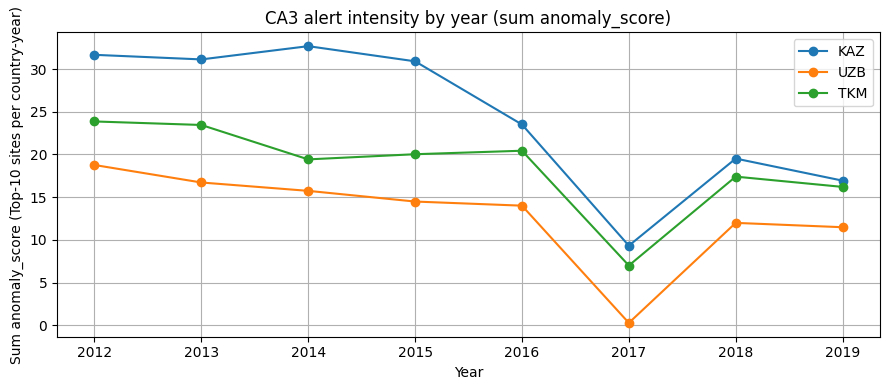

Saved: /content/outputs/alerts_intensity_anomaly_sum_ca3.png


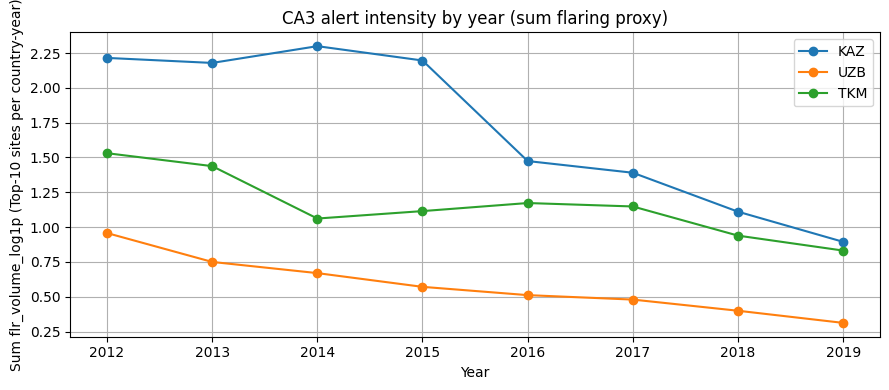

Saved: /content/outputs/alerts_intensity_flr_volume_sum_ca3.png


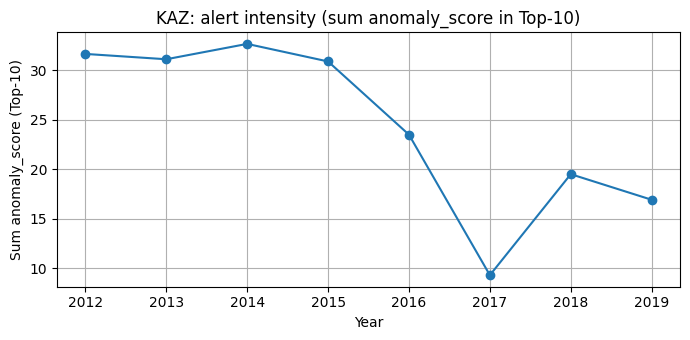

Saved: /content/outputs/alerts_intensity_anomaly_sum_KAZ.png


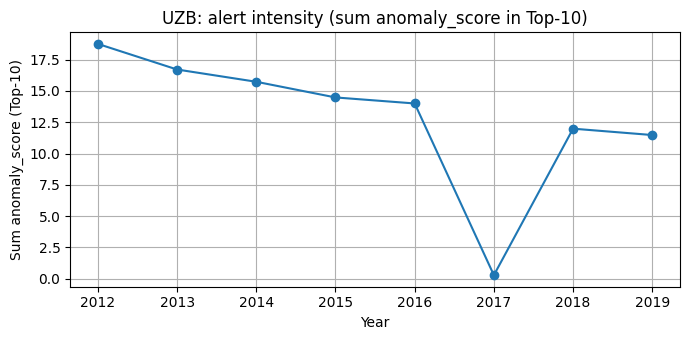

Saved: /content/outputs/alerts_intensity_anomaly_sum_UZB.png


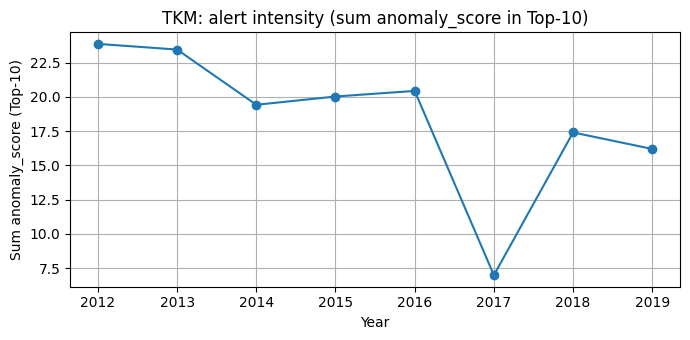

Saved: /content/outputs/alerts_intensity_anomaly_sum_TKM.png


In [10]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = Path("/content/outputs")

df_sites = pd.read_csv(OUT_DIR / "features_ca3_with_cluster_and_impact.csv")

# Hard check: CA3 only
CA3 = ["KAZ", "UZB", "TKM"]
bad = set(df_sites["cntry_iso"].unique()) - set(CA3)
if bad:
    raise ValueError(f"Non-CA3 countries found in df_sites: {sorted(list(bad))}")
print(f"CA3 countries present: {sorted(df_sites['cntry_iso'].unique())}")

def zscore(s: pd.Series) -> pd.Series:
    s = s.astype(float)
    return (s - s.mean()) / s.std(ddof=0)

# Stable, explainable anomaly_score
z_flr = zscore(df_sites["flr_volume_log1p"])
z_freq = zscore(df_sites["dtc_freq"])

clr = df_sites["clr_obs"].astype(float)
clr_q = (clr - clr.min()) / (clr.max() - clr.min())

df_sites["anomaly_score"] = 0.5 * z_flr + 0.5 * z_freq + 0.2 * clr_q

# Save full table with anomaly_score
df_sites.to_csv(OUT_DIR / "features_ca3_with_cluster_and_impact_and_alerts.csv", index=False)
print(f"Saved: {OUT_DIR / 'features_ca3_with_cluster_and_impact_and_alerts.csv'}")

# 1) Global Top-50 sites (jury artifact)
topN = 50
cols_out = [
    "site_id", "year", "cntry_iso", "cntry_name", "latitude", "longitude",
    "catalog_id", "flr_type", "cluster", "impact_class",
    "flr_volume_log1p", "dtc_freq", "clr_obs", "avg_temp", "ellip",
    "impact_score", "anomaly_score"
]
df_top50 = df_sites.sort_values("anomaly_score", ascending=False).head(topN)[cols_out].copy()
df_top50.to_csv(OUT_DIR / "alerts_sites_top50_ca3.csv", index=False)
print(f"Saved: {OUT_DIR / 'alerts_sites_top50_ca3.csv'}")
display(df_top50.head(15))

# 2) Country-year Top-10 (dashboard artifact)
top_per_group = 10
df_cy = (
    df_sites.sort_values("anomaly_score", ascending=False)
    .groupby(["cntry_iso", "year"], as_index=False, group_keys=False)
    .head(top_per_group)
    [cols_out]
    .copy()
)
df_cy.to_csv(OUT_DIR / "alerts_country_year_top10_ca3.csv", index=False)
print(f"Saved: {OUT_DIR / 'alerts_country_year_top10_ca3.csv'}")

# 3) Informative aggregation: intensity of alerts (not counts)
agg = (
    df_cy.groupby(["year", "cntry_iso"], as_index=False)
    .agg(
        anomaly_sum=("anomaly_score", "sum"),
        anomaly_mean=("anomaly_score", "mean"),
        flr_volume_log1p_sum=("flr_volume_log1p", "sum"),
        dtc_freq_sum=("dtc_freq", "sum"),
        clr_obs_mean=("clr_obs", "mean"),
    )
    .sort_values(["year", "cntry_iso"])
)
agg.to_csv(OUT_DIR / "alerts_country_year_top10_aggregates_ca3.csv", index=False)
print(f"Saved: {OUT_DIR / 'alerts_country_year_top10_aggregates_ca3.csv'}")
display(agg)

# ---- Plots (DPI 300) ----
# Plot 1: Sum anomaly_score in Top-10 per country-year
plt.figure(figsize=(9, 4))
for iso in CA3:
    d = agg[agg["cntry_iso"] == iso]
    plt.plot(d["year"], d["anomaly_sum"], marker="o", label=iso)
plt.xlabel("Year")
plt.ylabel("Sum anomaly_score (Top-10 sites per country-year)")
plt.title("CA3 alert intensity by year (sum anomaly_score)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "alerts_intensity_anomaly_sum_ca3.png", dpi=300)
plt.show()
print(f"Saved: {OUT_DIR / 'alerts_intensity_anomaly_sum_ca3.png'}")

# Plot 2: Sum flaring proxy in Top-10 per country-year
plt.figure(figsize=(9, 4))
for iso in CA3:
    d = agg[agg["cntry_iso"] == iso]
    plt.plot(d["year"], d["flr_volume_log1p_sum"], marker="o", label=iso)
plt.xlabel("Year")
plt.ylabel("Sum flr_volume_log1p (Top-10 sites per country-year)")
plt.title("CA3 alert intensity by year (sum flaring proxy)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "alerts_intensity_flr_volume_sum_ca3.png", dpi=300)
plt.show()
print(f"Saved: {OUT_DIR / 'alerts_intensity_flr_volume_sum_ca3.png'}")

# Plot 3 (optional but useful): split by country in separate panels (still one figure, cleaner view)
for iso in CA3:
    d = agg[agg["cntry_iso"] == iso]
    plt.figure(figsize=(7, 3.5))
    plt.plot(d["year"], d["anomaly_sum"], marker="o")
    plt.xlabel("Year")
    plt.ylabel("Sum anomaly_score (Top-10)")
    plt.title(f"{iso}: alert intensity (sum anomaly_score in Top-10)")
    plt.grid(True)
    plt.tight_layout()
    outp = OUT_DIR / f"alerts_intensity_anomaly_sum_{iso}.png"
    plt.savefig(outp, dpi=300)
    plt.show()
    print(f"Saved: {outp}")


# В данной ячейке формируется интерактивная карта CA3: алерты отображаются как точки, цветом кодируется класс воздействия (Low/Medium/High), а во всплывающем окне выводятся ключевые метрики. Дополнительно сохраняются GeoJSON и KML для внешних ГИС.

In [14]:
# CA3 interactive map (robust, no geopandas) - overwrites the same output HTML

!pip -q install folium requests

import os
import json
import numpy as np
import pandas as pd
import folium
from folium.plugins import MarkerCluster, HeatMap, Fullscreen, MeasureControl
import requests

os.makedirs("/content/outputs", exist_ok=True)

flare_path = "/content/outputs/flare_list_CA3_with_impact.csv"
alerts_path = "/content/outputs/alerts_sites_top50_ca3.csv"

if not os.path.exists(flare_path):
    raise FileNotFoundError(f"Not found: {flare_path}")
if not os.path.exists(alerts_path):
    raise FileNotFoundError(f"Not found: {alerts_path}")

df = pd.read_csv(flare_path)
alerts = pd.read_csv(alerts_path)

ca3 = {"KAZ", "UZB", "TKM"}
df = df[df.get("cntry_iso", "").isin(ca3)].copy()
alerts = alerts[alerts.get("cntry_iso", "").isin(ca3)].copy()

need_df = ["latitude","longitude","year","cntry_iso","cntry_name","impact_class","dtc_freq","clr_obs","avg_temp","ellip","flr_type","catalog_id","site_id"]
miss_df = [c for c in need_df if c not in df.columns]
if miss_df:
    raise ValueError(f"Missing columns in flare_list_CA3_with_impact.csv: {miss_df}")

need_al = ["latitude","longitude","year","cntry_iso","cntry_name","impact_class","anomaly_score","dtc_freq","clr_obs","avg_temp","ellip","flr_type","catalog_id","site_id"]
miss_al = [c for c in need_al if c not in alerts.columns]
if miss_al:
    raise ValueError(f"Missing columns in alerts_sites_top50_ca3.csv: {miss_al}")

df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
alerts["latitude"] = pd.to_numeric(alerts["latitude"], errors="coerce")
alerts["longitude"] = pd.to_numeric(alerts["longitude"], errors="coerce")

df = df.dropna(subset=["latitude","longitude"])
alerts = alerts.dropna(subset=["latitude","longitude"])

if "flr_volume_log1p" in df.columns:
    df["flr_proxy"] = pd.to_numeric(df["flr_volume_log1p"], errors="coerce").fillna(0.0)
elif "flr_volume" in df.columns:
    v = pd.to_numeric(df["flr_volume"], errors="coerce").fillna(0.0)
    df["flr_proxy"] = np.log1p(np.clip(v, 0.0, None))
else:
    df["flr_proxy"] = 1.0

if "flr_volume_log1p" in alerts.columns:
    alerts["flr_proxy"] = pd.to_numeric(alerts["flr_volume_log1p"], errors="coerce").fillna(0.0)
elif "flr_volume" in alerts.columns:
    v = pd.to_numeric(alerts["flr_volume"], errors="coerce").fillna(0.0)
    alerts["flr_proxy"] = np.log1p(np.clip(v, 0.0, None))
else:
    alerts["flr_proxy"] = 1.0

lat0 = float(df["latitude"].median())
lon0 = float(df["longitude"].median())

m = folium.Map(location=[lat0, lon0], zoom_start=5, tiles=None, control_scale=True)
folium.TileLayer("CartoDB positron", name="cartodbpositron", control=True).add_to(m)
folium.TileLayer("OpenStreetMap", name="openstreetmap", control=True).add_to(m)

Fullscreen(position="topleft").add_to(m)
MeasureControl(position="topleft").add_to(m)

# Boundaries (Natural Earth GeoJSON)
fg_bnd = folium.FeatureGroup(name="Границы стран (CA3)", show=True)

ne_url = "https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson"
geojson_path = "/content/outputs/ne_110m_admin_0_countries.geojson"

geo = None
try:
    if not os.path.exists(geojson_path):
        r = requests.get(ne_url, timeout=30)
        r.raise_for_status()
        with open(geojson_path, "wb") as f:
            f.write(r.content)
    with open(geojson_path, "r", encoding="utf-8") as f:
        geo = json.load(f)
except Exception as e:
    print(f"Warning: boundaries skipped (Natural Earth download/read failed): {e}")

if geo is not None and "features" in geo:
    keep = []
    for feat in geo["features"]:
        props = feat.get("properties", {}) or {}
        iso = props.get("ISO_A3") or props.get("ADM0_A3") or props.get("iso_a3") or props.get("adm0_a3")
        if iso in ca3:
            keep.append(feat)

    ca3_geo = {"type": "FeatureCollection", "features": keep}

    folium.GeoJson(
        ca3_geo,
        name="Границы стран (CA3)",
        style_function=lambda x: {"color": "#0066ff", "weight": 2, "fillOpacity": 0.03},
        tooltip=folium.GeoJsonTooltip(
            fields=["NAME"] if keep and ("NAME" in (keep[0].get("properties", {}) or {})) else [],
            aliases=["Страна"] if keep and ("NAME" in (keep[0].get("properties", {}) or {})) else [],
            sticky=False
        )
    ).add_to(fg_bnd)

fg_bnd.add_to(m)

# Heatmap
fg_heat = folium.FeatureGroup(name="Тепловая карта плотности (Heatmap)", show=False)
heat_data = df[["latitude","longitude","flr_proxy"]].values.tolist()
HeatMap(
    heat_data,
    min_opacity=0.25,
    radius=18,
    blur=22,
    max_zoom=8,
).add_to(fg_heat)
fg_heat.add_to(m)

# Per-year layers
color_map = {"Low": "green", "Medium": "orange", "High": "red"}
years = sorted(pd.to_numeric(df["year"], errors="coerce").dropna().astype(int).unique().tolist())

for y in years:
    fg_y = folium.FeatureGroup(name=f"Факелы: {y}", show=(y == max(years)))
    mc = MarkerCluster(disableClusteringAtZoom=9)

    sub = df[pd.to_numeric(df["year"], errors="coerce").astype("Int64") == y].copy()

    for _, r in sub.iterrows():
        c = color_map.get(str(r["impact_class"]), "blue")
        popup_html = f"""
        <b>Страна:</b> {r['cntry_iso']} ({r['cntry_name']})<br>
        <b>Год:</b> {int(y)}<br>
        <b>Impact:</b> {r['impact_class']}<br>
        <b>Flaring proxy (log1p):</b> {float(r['flr_proxy']):.6f}<br>
        <b>dtc_freq:</b> {float(r['dtc_freq']):.3f}<br>
        <b>clr_obs:</b> {float(r['clr_obs']):.1f}<br>
        <b>avg_temp:</b> {float(r['avg_temp']):.2f}<br>
        <b>ellip:</b> {float(r['ellip']):.4f}<br>
        <b>Тип:</b> {r['flr_type']}<br>
        <b>catalog_id:</b> {r['catalog_id']}<br>
        <b>site_id:</b> {r['site_id']}
        """
        folium.CircleMarker(
            location=[float(r["latitude"]), float(r["longitude"])],
            radius=4,
            color=c,
            fill=True,
            fill_opacity=0.70,
            weight=1,
            popup=folium.Popup(popup_html, max_width=380),
        ).add_to(mc)

    mc.add_to(fg_y)
    fg_y.add_to(m)

# Alerts layer
fg_alerts = folium.FeatureGroup(name="ALERTS: топ-50 объектов", show=True)
mc_a = MarkerCluster(disableClusteringAtZoom=10)

for _, r in alerts.iterrows():
    c = color_map.get(str(r["impact_class"]), "black")
    popup_html = f"""
    <b>ALERT</b><br>
    <b>Страна:</b> {r['cntry_iso']} ({r['cntry_name']})<br>
    <b>Год:</b> {int(r['year'])}<br>
    <b>Impact:</b> {r['impact_class']}<br>
    <b>Anomaly score:</b> {float(r['anomaly_score']):.3f}<br>
    <b>Flaring proxy (log1p):</b> {float(r['flr_proxy']):.6f}<br>
    <b>dtc_freq:</b> {float(r['dtc_freq']):.3f}<br>
    <b>clr_obs:</b> {float(r['clr_obs']):.1f}<br>
    <b>avg_temp:</b> {float(r['avg_temp']):.2f}<br>
    <b>ellip:</b> {float(r['ellip']):.4f}<br>
    <b>Тип:</b> {r['flr_type']}<br>
    <b>catalog_id:</b> {r['catalog_id']}<br>
    <b>site_id:</b> {r['site_id']}
    """
    folium.CircleMarker(
        location=[float(r["latitude"]), float(r["longitude"])],
        radius=7,
        color="black",
        weight=2,
        fill=True,
        fill_color=c,
        fill_opacity=0.85,
        popup=folium.Popup(popup_html, max_width=420),
    ).add_to(mc_a)

mc_a.add_to(fg_alerts)
fg_alerts.add_to(m)

legend_html = """
<div style="
position: fixed;
bottom: 20px; left: 20px; z-index: 9999;
background-color: white; padding: 10px 12px;
border: 2px solid #333; border-radius: 6px;
font-size: 13px; line-height: 18px;">
<b>Легенда (impact)</b><br>
<span style="display:inline-block;width:10px;height:10px;background:#008000;margin-right:6px;"></span>Низкий<br>
<span style="display:inline-block;width:10px;height:10px;background:#ffa500;margin-right:6px;"></span>Средний<br>
<span style="display:inline-block;width:10px;height:10px;background:#ff0000;margin-right:6px;"></span>Высокий
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

folium.LayerControl(collapsed=False).add_to(m)

out_html = "/content/outputs/ca3_flaring_watch_map_ru.html"
m.save(out_html)
print(f"Saved (overwritten): {out_html}")


Saved (overwritten): /content/outputs/ca3_flaring_watch_map_ru.html


In [15]:
import os, shutil
from google.colab import files

out_dir = "/content/outputs"
zip_base = "/content/outputs"  # будет outputs.zip

if not os.path.isdir(out_dir):
    raise FileNotFoundError(f"Folder not found: {out_dir}")

# удалить старый архив, если есть
if os.path.exists(zip_base + ".zip"):
    os.remove(zip_base + ".zip")

shutil.make_archive(zip_base, "zip", out_dir)
files.download(zip_base + ".zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>